#### Lesson: Schelling’s Segregation Model

In [1]:
from random import uniform, seed
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Exercise 1

![Ex1](img/schelling_1.png)

Entering loop  1


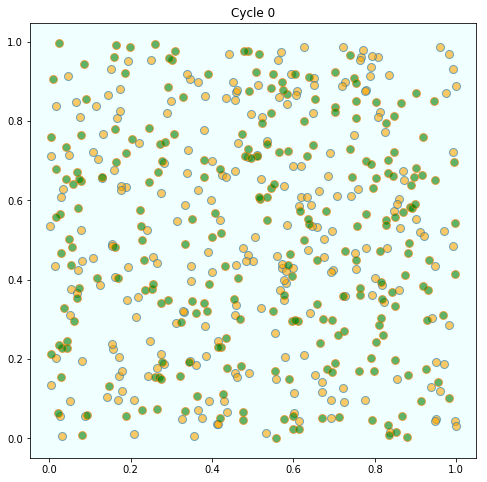

Entering loop  2


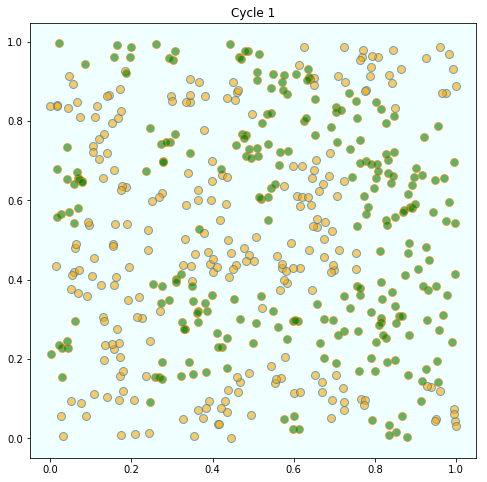

Entering loop  3


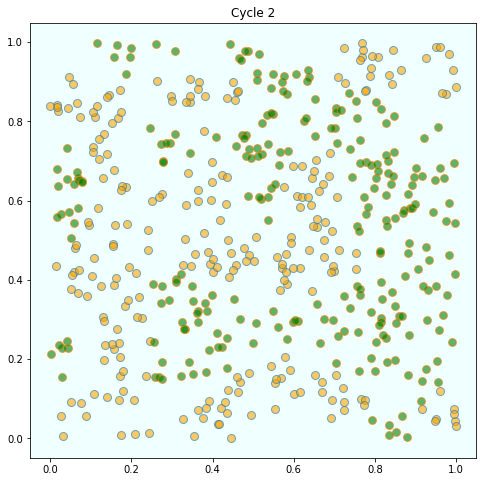

Entering loop  4


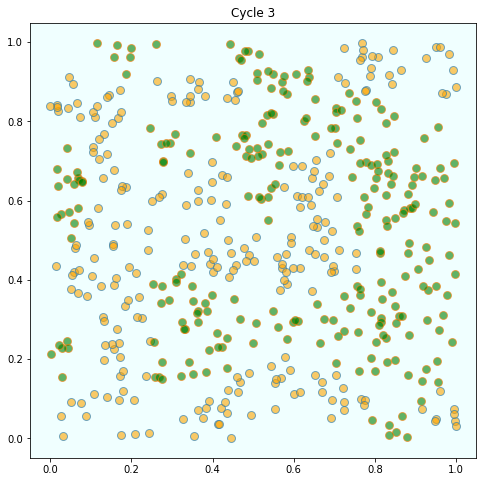

Converged, terminating.


In [2]:
seed(10)  # For reproducible random numbers

class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "Computes the euclidean distance between self and other agent."
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self, agents):
        "True if sufficient number of nearest neighbors are of the same type."
        distances = []
        # distances is a list of pairs (d, agent), where d is distance from
        # agent to self
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))
        # == Sort from smallest to largest, according to distance == #
        distances.sort()
        # == Extract the neighboring agents == #
        neighbors = [agent for d, agent in distances[:num_neighbors]]
        # == Count how many neighbors have the same type as self == #
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "If not happy, then randomly choose new locations until happy."
        while not self.happy(agents):
            self.draw_location()


def plot_distribution(agents, cycle_num):
    "Plot the distribution of agents after cycle_num rounds of the loop."
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == Obtain locations of each type == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots(figsize=(8, 8))
    plot_args = {'markersize': 8, 'alpha': 0.6}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0, 'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1, 'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

# == Main == #

num_of_type_0 = 250
num_of_type_1 = 250
num_neighbors = 10      # Number of agents regarded as neighbors
require_same_type = 5   # Want at least this many neighbors to be same type

# == Create a list of agents == #
agents = [Agent(0) for i in range(num_of_type_0)]
agents.extend(Agent(1) for i in range(num_of_type_1))


count = 1
# ==  Loop until none wishes to move == #
while True:
    print('Entering loop ', count)
    plot_distribution(agents, count)
    count += 1
    no_one_moved = True
    for agent in agents:
        old_location = agent.location
        agent.update(agents)
        if agent.location != old_location:
            no_one_moved = False
    if no_one_moved:
        break

print('Converged, terminating.')

#### Lesson: A Lake Model of Employment and Unemployment

In [1]:
import numpy as np
from quantecon import MarkovChain
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.optimize import brentq
from quantecon.distributions import BetaBinomial
from numba import jit

In [2]:
class LakeModel:
    """
    Solves the lake model and computes dynamics of unemployment stocks and
    rates.

    Parameters:
    ------------
    λ : scalar
        The job finding rate for currently unemployed workers
    α : scalar
        The dismissal rate for currently employed workers
    b : scalar
        Entry rate into the labor force
    d : scalar
        Exit rate from the labor force

    """
    def __init__(self, λ=0.283, α=0.013, b=0.0124, d=0.00822):
        self._λ, self._α, self._b, self._d = λ, α, b, d
        self.compute_derived_values()

    def compute_derived_values(self):
        # Unpack names to simplify expression
        λ, α, b, d = self._λ, self._α, self._b, self._d

        self._g = b - d
        self._A = np.array([[(1-d) * (1-λ) + b,      (1 - d) * α + b],
                            [        (1-d) * λ,   (1 - d) * (1 - α)]])

        self._A_hat = self._A / (1 + self._g)

    @property
    def g(self):
        return self._g

    @property
    def A(self):
        return self._A

    @property
    def A_hat(self):
        return self._A_hat

    @property
    def λ(self):
        return self._λ

    @λ.setter
    def λ(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def α(self):
        return self._α

    @α.setter
    def α(self, new_value):
        self._α = new_value
        self.compute_derived_values()

    @property
    def b(self):
        return self._b

    @b.setter
    def b(self, new_value):
        self._b = new_value
        self.compute_derived_values()

    @property
    def d(self):
        return self._d

    @d.setter
    def d(self, new_value):
        self._d = new_value
        self.compute_derived_values()


    def rate_steady_state(self, tol=1e-6):
        """
        Finds the steady state of the system :math:`x_{t+1} = \hat A x_{t}`

        Returns
        --------
        xbar : steady state vector of employment and unemployment rates
        """
        x = 0.5 * np.ones(2)
        error = tol + 1
        while error > tol:
            new_x = self.A_hat @ x
            error = np.max(np.abs(new_x - x))
            x = new_x
        return x

    def simulate_stock_path(self, X0, T):
        """
        Simulates the sequence of Employment and Unemployment stocks

        Parameters
        ------------
        X0 : array
            Contains initial values (E0, U0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        X : iterator
            Contains sequence of employment and unemployment stocks
        """

        X = np.atleast_1d(X0)  # Recast as array just in case
        for t in range(T):
            yield X
            X = self.A @ X

    def simulate_rate_path(self, x0, T):
        """
        Simulates the sequence of employment and unemployment rates

        Parameters
        ------------
        x0 : array
            Contains initial values (e0,u0)
        T : int
            Number of periods to simulate

        Returns
        ---------
        x : iterator
            Contains sequence of employment and unemployment rates

        """
        x = np.atleast_1d(x0)  # Recast as array just in case
        for t in range(T):
            yield x
            x = self.A_hat @ x

In [3]:
lm = LakeModel()
lm.α

0.013

In [4]:
lm.A

array([[0.72350626, 0.02529314],
       [0.28067374, 0.97888686]])

In [5]:
lm.α = 2
lm.A

array([[ 0.72350626,  1.99596   ],
       [ 0.28067374, -0.99178   ]])

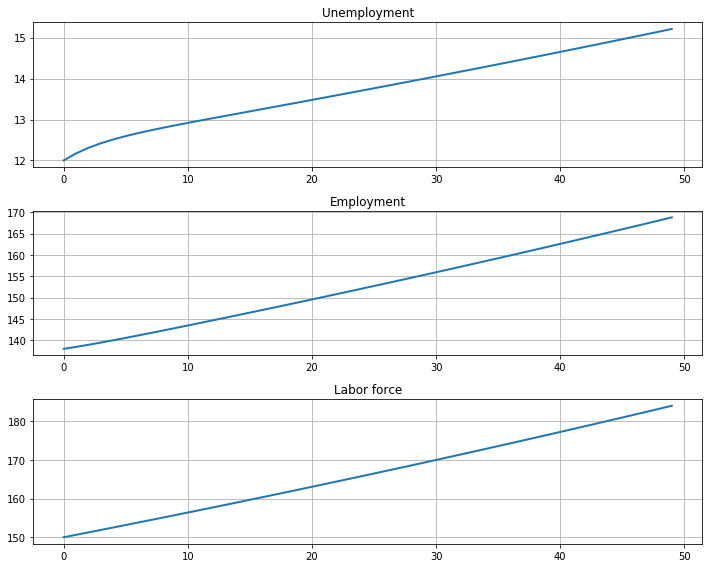

In [6]:
lm = LakeModel()
N_0 = 150      # Population
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

U_0 = u_0 * N_0
E_0 = e_0 * N_0

fig, axes = plt.subplots(3, 1, figsize=(10, 8))
X_0 = (U_0, E_0)
X_path = np.vstack(tuple(lm.simulate_stock_path(X_0, T)))

axes[0].plot(X_path[:, 0], lw=2)
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1], lw=2)
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1), lw=2)
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

In [7]:
lm = LakeModel()
e, f = np.linalg.eigvals(lm.A_hat)
abs(e), abs(f)

(0.6953067378358462, 1.0)

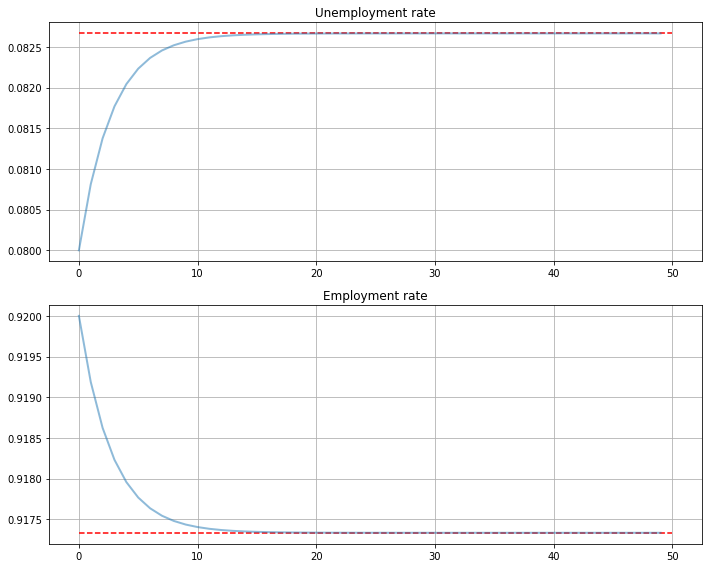

In [8]:
lm = LakeModel()
e_0 = 0.92     # Initial employment rate
u_0 = 1 - e_0  # Initial unemployment rate
T = 50         # Simulation length

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
x_0 = (u_0, e_0)
x_path = np.vstack(tuple(lm.simulate_rate_path(x_0, T)))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i], lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()



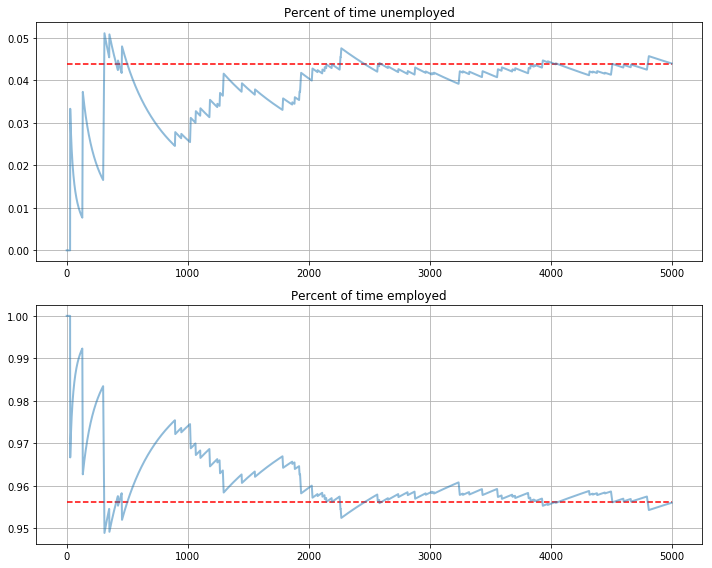

In [9]:
lm = LakeModel(d=0, b=0)
T = 5000  # Simulation length

α, λ = lm.α, lm.λ

P = [[1 - λ,        λ],
    [    α,    1 - α]]

mc = MarkovChain(P)

xbar = lm.rate_steady_state()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
s_path = mc.simulate(T, init=1)
s_bar_e = s_path.cumsum() / range(1, T+1)
s_bar_u = 1 - s_bar_e

to_plot = [s_bar_u, s_bar_e]
titles = ['Percent of time unemployed', 'Percent of time employed']

for i, plot in enumerate(to_plot):
    axes[i].plot(plot, lw=2, alpha=0.5)
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(titles[i])
    axes[i].grid()

plt.tight_layout()
plt.show()



In [10]:
# A default utility function

@jit
def u(c, σ):
    if c > 0:
        return (c**(1 - σ) - 1) / (1 - σ)
    else:
        return -10e6


class McCallModel:
    """
    Stores the parameters and functions associated with a given model.
    """

    def __init__(self,
                α=0.2,       # Job separation rate
                β=0.98,      # Discount rate
                γ=0.7,       # Job offer rate
                c=6.0,       # Unemployment compensation
                σ=2.0,       # Utility parameter
                w_vec=None,  # Possible wage values
                p_vec=None): # Probabilities over w_vec

        self.α, self.β, self.γ, self.c = α, β, γ, c
        self.σ = σ

        # Add a default wage vector and probabilities over the vector using
        # the beta-binomial distribution
        if w_vec is None:
            n = 60  # Number of possible outcomes for wage
            # Wages between 10 and 20
            self.w_vec = np.linspace(10, 20, n)
            a, b = 600, 400  # Shape parameters
            dist = BetaBinomial(n-1, a, b)
            self.p_vec = dist.pdf()
        else:
            self.w_vec = w_vec
            self.p_vec = p_vec

@jit
def _update_bellman(α, β, γ, c, σ, w_vec, p_vec, V, V_new, U):
    """
    A jitted function to update the Bellman equations.  Note that V_new is
    modified in place (i.e, modified by this function).  The new value of U
    is returned.

    """
    for w_idx, w in enumerate(w_vec):
        # w_idx indexes the vector of possible wages
        V_new[w_idx] = u(w, σ) + β * ((1 - α) * V[w_idx] + α * U)

    U_new = u(c, σ) + β * (1 - γ) * U + \
                    β * γ * np.sum(np.maximum(U, V) * p_vec)

    return U_new


def solve_mccall_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    Parameters
    ----------
    mcm : an instance of McCallModel
    tol : float
        error tolerance
    max_iter : int
        the maximum number of iterations
    """

    V = np.ones(len(mcm.w_vec))  # Initial guess of V
    V_new = np.empty_like(V)     # To store updates to V
    U = 1                        # Initial guess of U
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        U_new = _update_bellman(mcm.α, mcm.β, mcm.γ,
                mcm.c, mcm.σ, mcm.w_vec, mcm.p_vec, V, V_new, U)
        error_1 = np.max(np.abs(V_new - V))
        error_2 = np.abs(U_new - U)
        error = max(error_1, error_2)
        V[:] = V_new
        U = U_new
        i += 1

    return V, U

In [11]:
def compute_reservation_wage(mcm, return_values=False):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that V(w) > U.

    If V(w) > U for all w, then the reservation wage w_bar is set to
    the lowest wage in mcm.w_vec.

    If v(w) < U for all w, then w_bar is set to np.inf.

    Parameters
    ----------
    mcm : an instance of McCallModel
    return_values : bool (optional, default=False)
        Return the value functions as well

    Returns
    -------
    w_bar : scalar
        The reservation wage

    """

    V, U = solve_mccall_model(mcm)
    w_idx = np.searchsorted(V - U, 0)

    if w_idx == len(V):
        w_bar = np.inf
    else:
        w_bar = mcm.w_vec[w_idx]

    if return_values == False:
        return w_bar
    else:
        return w_bar, V, U

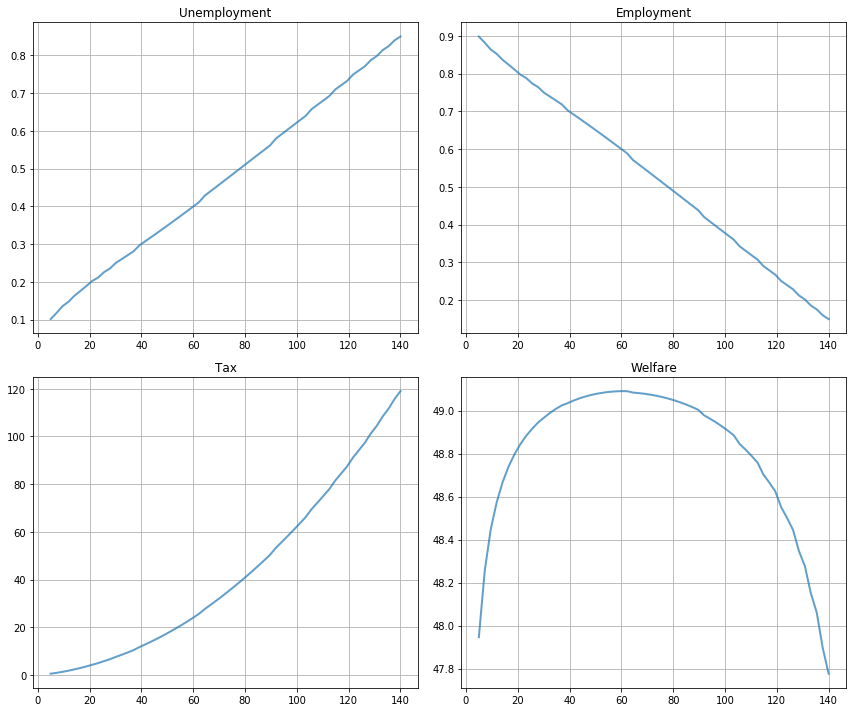

In [12]:
# Some global variables that will stay constant
α = 0.013
α_q = (1-(1-α)**3)   # Quarterly (α is monthly)
b = 0.0124
d = 0.00822
β = 0.98
γ = 1.0
σ = 2.0

# The default wage distribution --- a discretized lognormal
log_wage_mean, wage_grid_size, max_wage = 20, 200, 170
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(1e-8, max_wage, wage_grid_size + 1)
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:] - cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1]) / 2


def compute_optimal_quantities(c, τ):
    """
    Compute the reservation wage, job finding rate and value functions
    of the workers given c and τ.

    """

    mcm = McCallModel(α=α_q,
                    β=β,
                    γ=γ,
                    c=c-τ,          # Post tax compensation
                    σ=σ,
                    w_vec=w_vec-τ,  # Post tax wages
                    p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    λ = γ * np.sum(p_vec[w_vec - τ > w_bar])
    return w_bar, λ, V, U

def compute_steady_state_quantities(c, τ):
    """
    Compute the steady state unemployment rate given c and τ using optimal
    quantities from the McCall model and computing corresponding steady
    state quantities

    """
    w_bar, λ, V, U = compute_optimal_quantities(c, τ)

    # Compute steady state employment and unemployment rates
    lm = LakeModel(α=α_q, λ=λ, b=b, d=d)
    x = lm.rate_steady_state()
    u, e = x

    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec - τ > w_bar)) / np.sum(p_vec * (w_vec -
            τ > w_bar))
    welfare = e * w + u * U

    return e, u, welfare


def find_balanced_budget_tax(c):
    """
    Find the tax level that will induce a balanced budget.

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    τ = brentq(steady_state_budget, 0.0, 0.9 * c)
    return τ


# Levels of unemployment insurance we wish to study
c_vec = np.linspace(5, 140, 60)

tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plots = [unempl_vec, empl_vec, tax_vec, welfare_vec]
titles = ['Unemployment', 'Employment', 'Tax', 'Welfare']

for ax, plot, title in zip(axes.flatten(), plots, titles):
    ax.plot(c_vec, plot, lw=2, alpha=0.7)
    ax.set_title(title)
    ax.grid()

plt.tight_layout()
plt.show()

Exercise 1

![Ex1](img/lake_1.png)

In [14]:
lm = LakeModel()
x0 = lm.rate_steady_state()
print(f"Initial Steady State: {x0}")

Initial Steady State: [0.08266806 0.91733194]


In [15]:
N0 = 100
T = 50

In [16]:
lm.lmda = 0.2

xbar = lm.rate_steady_state()  # new steady state
X_path = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T)))
x_path = np.vstack(tuple(lm.simulate_rate_path(x0, T)))
print(f"New Steady State: {xbar}")

New Steady State: [0.08266806 0.91733194]


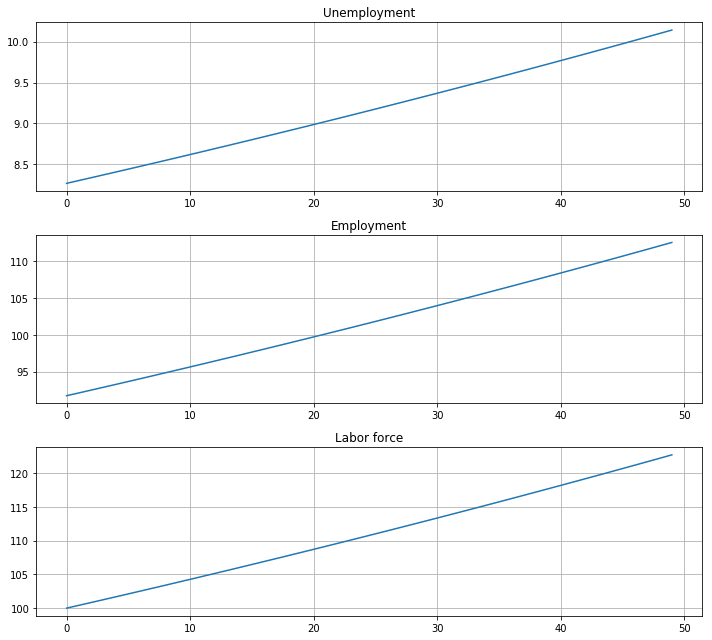

In [17]:
fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()



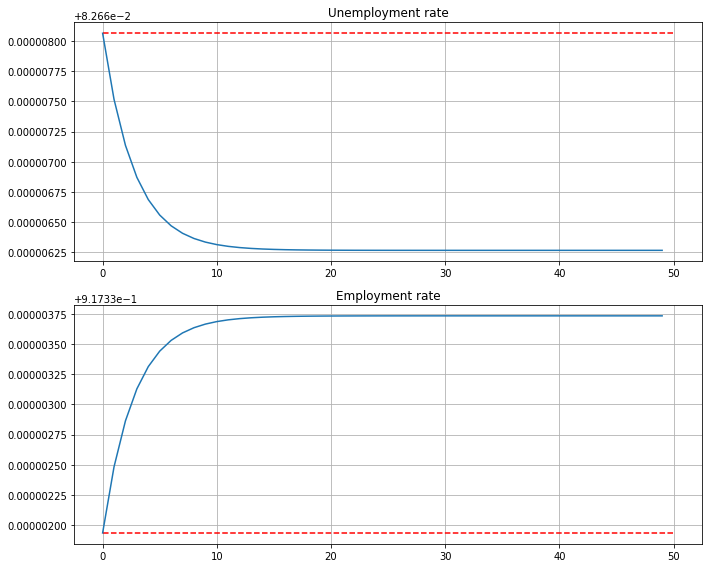

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(xbar[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()

Exercise 2

![Ex2](img/lake_2.png)

In [19]:
lm = LakeModel()
x0 = lm.rate_steady_state()

In [20]:
b_hat = 0.003
T_hat = 20

In [21]:
lm.b = b_hat
# Simulate stocks
X_path1 = np.vstack(tuple(lm.simulate_stock_path(x0 * N0, T_hat)))
# Simulate rates
x_path1 = np.vstack(tuple(lm.simulate_rate_path(x0, T_hat)))

In [22]:
lm.b = 0.0124
# Simulate stocks
X_path2 = np.vstack(tuple(lm.simulate_stock_path(X_path1[-1, :2], T-T_hat+1)))
# Simulate rates
x_path2 = np.vstack(tuple(lm.simulate_rate_path(x_path1[-1, :2], T-T_hat+1)))

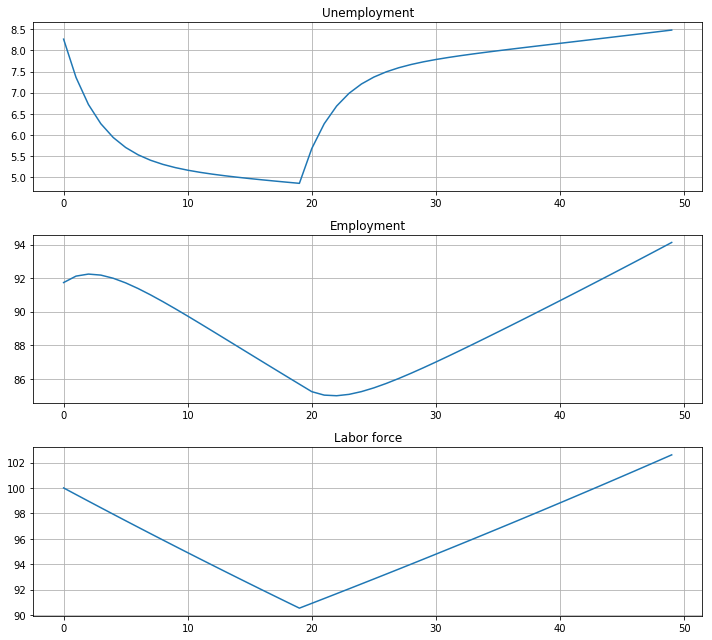

In [23]:
# note [1:] to avoid doubling period 20
x_path = np.vstack([x_path1, x_path2[1:]])
X_path = np.vstack([X_path1, X_path2[1:]])

fig, axes = plt.subplots(3, 1, figsize=[10, 9])

axes[0].plot(X_path[:, 0])
axes[0].set_title('Unemployment')

axes[1].plot(X_path[:, 1])
axes[1].set_title('Employment')

axes[2].plot(X_path.sum(1))
axes[2].set_title('Labor force')

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()



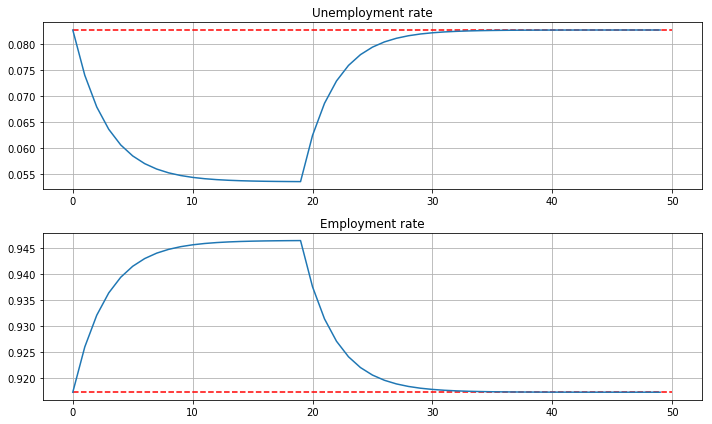

In [24]:
fig, axes = plt.subplots(2, 1, figsize=[10, 6])

titles = ['Unemployment rate', 'Employment rate']

for i, title in enumerate(titles):
    axes[i].plot(x_path[:, i])
    axes[i].hlines(x0[i], 0, T, 'r', '--')
    axes[i].set_title(title)
    axes[i].grid()

plt.tight_layout()
plt.show()